<a href="https://colab.research.google.com/github/manikandanssp2001/brain-tumor-detection-and-segmentation/blob/main/brain_tumor_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!kaggle datasets download -d masoudnickparvar/brain-tumor-mri-dataset

Dataset URL: https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset
License(s): CC0-1.0
 99% 147M/149M [00:00<00:00, 244MB/s]
100% 149M/149M [00:00<00:00, 225MB/s]


In [ ]:
!unzip /content/brain-tumor-mri-dataset.zip -d /content/

Streaming output truncated to the last 5000 lines.
  inflating: /content/Training/glioma/Tr-gl_0712.jpg  
  inflating: /content/Training/glioma/Tr-gl_0713.jpg  
  inflating: /content/Training/glioma/Tr-gl_0714.jpg  
  inflating: /content/Training/glioma/Tr-gl_0715.jpg  
  inflating: /content/Training/glioma/Tr-gl_0716.jpg  
  inflating: /content/Training/glioma/Tr-gl_0717.jpg  
  inflating: /content/Training/glioma/Tr-gl_0718.jpg  
  inflating: /content/Training/glioma/Tr-gl_0719.jpg  
  inflating: /content/Training/glioma/Tr-gl_0720.jpg  
  inflating: /content/Training/glioma/Tr-gl_0721.jpg  
  inflating: /content/Training/glioma/Tr-gl_0722.jpg  
  inflating: /content/Training/glioma/Tr-gl_0723.jpg  
  inflating: /content/Training/glioma/Tr-gl_0724.jpg  
  inflating: /content/Training/glioma/Tr-gl_0725.jpg  
  inflating: /content/Training/glioma/Tr-gl_0726.jpg  
  inflating: /content/Training/glioma/Tr-gl_0727.jpg  
  inflating: /content/Training/glioma/Tr-gl_0728.jpg  
  inflating: /

In [ ]:
!pip install imutils

  Preparing metadata (setup.py) ... done
  Created wheel for imutils: filename=imutils-0.5.4-py3-none-any.whl size=25836 sha256=5c2aa28aff1fae40e5e84066cd5c0128f778c89bec11cdd87f0b2e8daee74beb
  Stored in directory: /root/.cache/pip/wheels/85/cf/3a/e265e975a1e7c7e54eb3692d6aa4e2e7d6a3945d29da46f2d7
Successfully built imutils


In [ ]:
!pip install cv

In [ ]:
# Import necessary modules

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

from imutils import paths
import numpy as np
import matplotlib.pyplot as plt
import argparse
import os
import cv2


In [ ]:
# Load the images directories
train_path = "/content/Training"
print(os.listdir(train_path))

image_paths = list(paths.list_images(train_path))
print(len(image_paths))

['meningioma', 'glioma', 'pituitary', 'notumor']
5712


In [ ]:
test_path = "/content/Testing"
print(os.listdir(test_path))

image_paths = list(paths.list_images(test_path))
print(len(image_paths))

['meningioma', 'glioma', 'pituitary', 'notumor']
1311


In [ ]:
# Import necessary modules
# ... (your existing imports) ...
from tensorflow.keras.preprocessing.image import img_to_array  # Import img_to_array

# Initialize the data and labels lists
train_data = []
train_labels = []
test_data = []
test_labels = []

# Define the target image size (for resizing the images to a uniform size)
target_size = (224, 224)  # You can change this depending on your model's input size

# Class names: meningioma, glioma, pituitary, and notumor
class_names = ['meningioma', 'glioma', 'pituitary', 'notumor']

# Load the training images
for folder_name in os.listdir(train_path): # Iterate through subfolders in train_path
    folder_path = os.path.join(train_path, folder_name)
    if os.path.isdir(folder_path): # Ensure it's a directory
        for filename in os.listdir(folder_path): # Iterate through images in subfolder
            image_path = os.path.join(folder_path, filename)

            # Load the image
            image = cv2.imread(image_path)

            # Check if image loaded successfully
            if image is not None:
                image = cv2.resize(image, target_size)
                image = img_to_array(image)
                train_data.append(image)

                # Extract the label (using the folder name)
                label = class_names.index(folder_name)
                train_labels.append(label)
            else:
                print(f"Error loading image: {image_path}")

# Convert the data to numpy arrays and normalize pixel values
train_data = np.array(train_data, dtype="float32") / 255.0
train_labels = np.array(train_labels)

# Convert labels to one-hot encoding
train_labels = to_categorical(train_labels, num_classes=4)

In [ ]:
# Load the testing images
for folder_name in os.listdir(test_path):  # Iterate through subfolders in test_path
    folder_path = os.path.join(test_path, folder_name)
    if os.path.isdir(folder_path):  # Ensure it's a directory
        for filename in os.listdir(folder_path):  # Iterate through images in subfolder
            image_path = os.path.join(folder_path, filename)

            # Load the image
            image = cv2.imread(image_path)

            # Check if image loaded successfully
            if image is not None:
                image = cv2.resize(image, target_size)
                image = img_to_array(image)
                test_data.append(image)

                # Extract the label (using the folder name)
                label = class_names.index(folder_name)
                test_labels.append(label)
            else:
                print(f"Error loading image: {image_path}")

# Convert the data to numpy arrays and normalize pixel values
test_data = np.array(test_data, dtype="float32") / 255.0
test_labels = np.array(test_labels)

# Convert labels to one-hot encoding
test_labels = to_categorical(test_labels, num_classes=4)

In [ ]:
import tensorflow as tf
from tensorflow.keras import regularizers, layers, models
from sklearn.model_selection import train_test_split
# Split the training data into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(train_data, train_labels, test_size=0.2, random_state=42)

# **Change 1: Update input_shape to (224, 224, 3)**
model6 = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),  # Updated input_shape
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    layers.Dropout(0.5),
    layers.Dense(4, activation='softmax')
])
# Compile the model
model6.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Convert one-hot encoded labels to class indices
y_train_indices = np.argmax(y_train, axis=1)

# Calculate class weights using the class indices
class_weights = compute_class_weight('balanced', classes=np.unique(y_train_indices), y=y_train_indices)
class_weight_dict = dict(enumerate(class_weights))

history=model6.fit(
    X_train, y_train,
    epochs=15,
    validation_data=(X_val, y_val),
    class_weight=class_weight_dict
)

Epoch 1/15
143/143 [==============================] - 65s 445ms/step - loss: 1.4196 - accuracy: 0.6393 - val_loss: 0.9933 - val_accuracy: 0.7717
Epoch 2/15
143/143 [==============================] - 62s 434ms/step - loss: 0.9390 - accuracy: 0.7717 - val_loss: 0.8448 - val_accuracy: 0.8075
Epoch 3/15
143/143 [==============================] - 63s 440ms/step - loss: 0.8448 - accuracy: 0.7978 - val_loss: 0.7609 - val_accuracy: 0.8338
Epoch 4/15
143/143 [==============================] - 63s 444ms/step - loss: 0.8207 - accuracy: 0.8210 - val_loss: 0.7980 - val_accuracy: 0.8014
Epoch 5/15
143/143 [==============================] - 63s 443ms/step - loss: 0.7531 - accuracy: 0.8439 - val_loss: 0.6904 - val_accuracy: 0.8635
Epoch 6/15
143/143 [==============================] - 63s 441ms/step - loss: 0.6926 - accuracy: 0.8643 - val_loss: 0.6594 - val_accuracy: 0.8460
Epoch 7/15
143/143 [==============================] - 63s 440ms/step - loss: 0.6500 - accuracy: 0.8792 - val_loss: 0.6136 - val_ac

In [ ]:
loss,accuracy=model6.evaluate(test_data,test_labels)
print("Loss: ",loss)
print("Accuracy: ",accuracy)

41/41 [==============================] - 3s 83ms/step - loss: 0.6674 - accuracy: 0.8673
Loss:  0.6674345135688782
Accuracy:  0.8672769069671631


In [ ]:
model6.save("tumor_detection.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


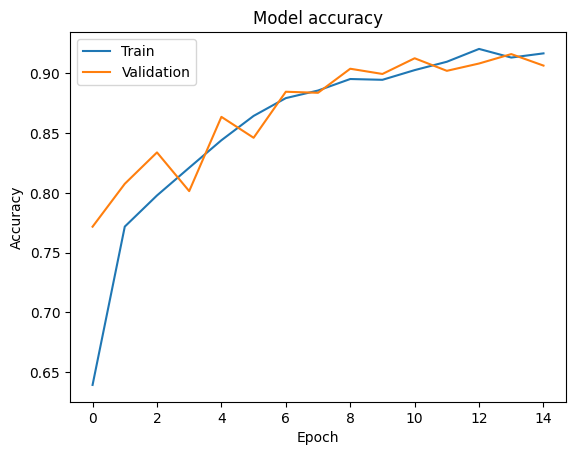

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

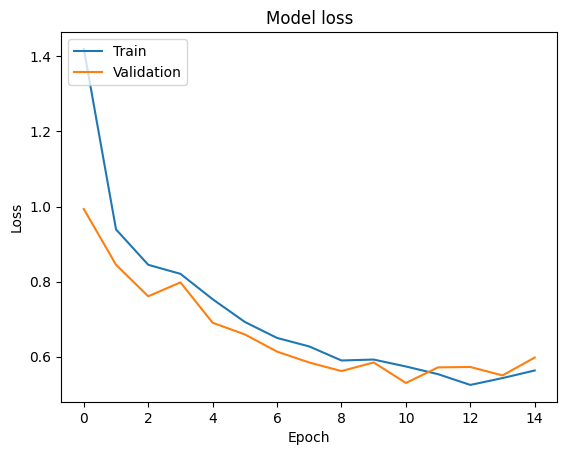

In [ ]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
from sklearn.metrics import classification_report
import numpy as np

# Predict on the validation set
y_pred = model6.predict(X_val)

# Convert predictions to class labels (use np.argmax for one-hot encoded labels)
y_pred_labels = np.argmax(y_pred, axis=1)
y_val_labels = np.argmax(y_val, axis=1)

# Generate the classification report
report = classification_report(y_val_labels, y_pred_labels)
print(report)


36/36 [==============================] - 3s 80ms/step
              precision    recall  f1-score   support

           0       0.82      0.84      0.83       293
           1       0.93      0.88      0.91       260
           2       0.95      0.95      0.95       273
           3       0.93      0.95      0.94       317

    accuracy                           0.91      1143
   macro avg       0.91      0.91      0.91      1143
weighted avg       0.91      0.91      0.91      1143



In [ ]:
from sklearn.metrics import classification_report
import numpy as np

# Predict on the validation set
y_pred = model6.predict(test_data)

# Convert predictions to class labels (use np.argmax for one-hot encoded labels)
y_pred_labels = np.argmax(y_pred, axis=1)
y_val_labels = np.argmax(test_labels, axis=1)

# Generate the classification report
report = classification_report(y_val_labels, y_pred_labels)
print(report)


41/41 [==============================] - 3s 78ms/step
              precision    recall  f1-score   support

           0       0.73      0.74      0.73       306
           1       0.91      0.83      0.87       300
           2       0.93      0.91      0.92       300
           3       0.90      0.96      0.93       405

    accuracy                           0.87      1311
   macro avg       0.87      0.86      0.86      1311
weighted avg       0.87      0.87      0.87      1311

